<a href="https://colab.research.google.com/github/langfordzd/bursts-cc-pt/blob/main/burst_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction




# Let's load data and scripts from monkey LFP, mouse LFP, and monkey ECoG
We will grab the data from osf.io and the python files we need from github. The dataframes with the names of mouse, lfp (marco,pablo), and ecog are the results of both the CC and PTA method. The ones appended _trials are the actual data, appended _bs is behavior of the trial structures, and _ids is the total number of trials. We don't look at the mouse behavior so it is missing. We then import the .py files we grabbed from github. These are all helpers for each of the panel plots, and for calculating statistics. 

In [1]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [2]:
#!rm /content/*
#!rm -rf burst-cc-pt

In [3]:
!git clone https://github.com/langfordzd/bursts-cc-pt.git

Cloning into 'bursts-cc-pt'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 10), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [4]:
import sys
sys.path.insert(0,'/content/bursts-cc-pt')
#%cd burst-methods

In [5]:
!curl -L -J -O 'https://osf.io/anbf8/download'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   469  100   469    0     0    326      0  0:00:01  0:00:01 --:--:--   326
100 2834M  100 2834M    0     0  13.2M      0  0:03:33  0:03:33 --:--:-- 13.8M
curl: Saved to filename 'results.zip'


In [6]:
!unzip results.zip

Archive:  results.zip
  inflating: ecog_com.json           
  inflating: ecog_com.pkl            
  inflating: ecog_objs.pkl           
  inflating: lfp_com.json            
  inflating: lfp_com.pkl             
  inflating: lfp_objs.pkl            
  inflating: mouse_com.json          
  inflating: mouse_com.pkl           
  inflating: mouse_objs.pkl          


In [7]:
import pandas as pd
import json
with open("mouse_com.json", "r") as fp:  
    mouse = pd.read_json(json.load(fp)) 
with open("lfp_com.json", "rb") as fp:   
    lfp = pd.read_json(json.load(fp))
    lfp['loc'] = lfp['loc']+lfp['chan'].astype(str)
    lfp['monkey'] = lfp['loc'].astype(str).str[0]
    marco = lfp[lfp['monkey']=='M']
    pablo = lfp[lfp['monkey']=='P']
with open("ecog_com.json", "rb") as fp:   
    ecog = pd.read_json(json.load(fp))     

In [8]:
import pickle
with open("ecog_objs.pkl", "rb") as fp:  
    ecog_trials, ecog_bs, ecog_ids, _, _, _ = pickle.load(fp)
with open("lfp_objs.pkl", "rb") as fp:  
    lfp_trials, lfp_bs, lfp_ids, _, _ = pickle.load(fp)

In [9]:
#import os
#os.getcwd()
#os.chdir('/content/drive/MyDrive/bursts_notebook')
import matplotlib as mpl
import plot1, plot2, plot3

#First we look at how each method recovers bursts in a simulation

# Burst Characteristics

In this plot we see duration scattered against amplitude in the 3 leftmost plots for the PTA, CC, and CO(mmon) bursts found in the mouse (**A**), LFP (**B**), and ECoG (**C**) datasets. The rightmost plots show the frequency of the detected bursts for each method and dataset.

Neurodsp etc

**Note:** We should keep in mind that for a burst to be in the common plot it has to have 50% overlap between PTA and CC bursts, and not more than twice as long. If the relax these constraints we get the same picture in any case.

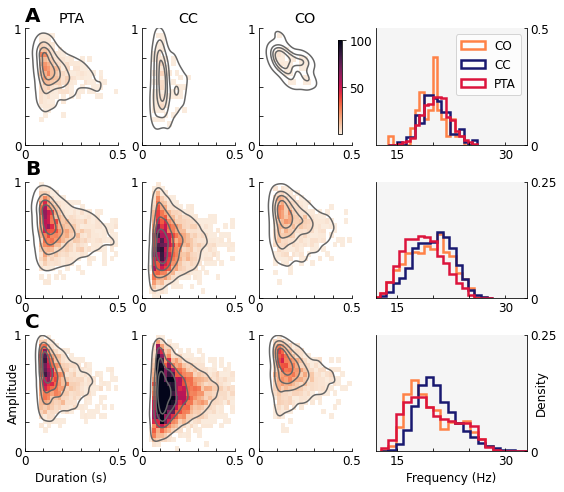

In [10]:
plot1.amp_dur(mouse,lfp,ecog)


#Duration, amplitude, frequency, and count differences abound
What we see here are paired sampled tests done on the unique bursts (i.e., the CC and PTA plots above) averaged per unit (e.g., ECoG session, or LFP channel). We have the Wilcoxon signed rank, the traditional t-test, and then a permutation t-test ([10,0.001] means 10 of 10000 permutations was more or less extreme than the observed. 
###Duration
For all but the ECoG data the duration of the CC method was shorter than the PTA method. We should keep in mind though that each method could give different time-points for the same burst (e.g., CC method will start and stop on a cycle trough, but PTA doesn't have this constratint). 
###Amplitude
For each dataset we analyzed we see that the CC method gives us lower amplitude bursts, as well as higher amplitude bursts.
###Frequency
Interestingly the frequency in the PTA method is lower, in both the LFP and ECoG data.
###Count
Possibly the most striking difference is in the count of bursts with the CC method giving 2-4 times the amount of bursts (with the exception of the mouse data, in which the CC method didn't find many bursts). 


In [11]:
plot1.print_stats(mouse,'duration', 'mouse')
plot1.print_stats(marco,'duration', 'marco')
plot1.print_stats(pablo,'duration', 'pablo')
plot1.print_stats(ecog,'duration', 'ecog')


--------------------------------------------
mouse
duration
[' PT:', '0.154', '0.00733', 'vs CC:', '0.115', '0.00942']
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
Ttest_relResult(statistic=-11.075990483318815, pvalue=1.5190886793362269e-06)
[0, 0.0]
--------------------------------------------
marco
duration
[' PT:', '0.169', '0.0143', 'vs CC:', '0.13', '0.00908']
WilcoxonResult(statistic=0.0, pvalue=0.0009815397525216685)
Ttest_relResult(statistic=-12.626318624462817, pvalue=1.1325587796588247e-08)
[0, 0.0]
--------------------------------------------
pablo
duration
[' PT:', '0.166', '0.0408', 'vs CC:', '0.144', '0.0111']
WilcoxonResult(statistic=17.0, pvalue=0.004853230851379527)
Ttest_relResult(statistic=-2.138097111655274, pvalue=0.0482849040276492)
[31, 0.0031]
--------------------------------------------
ecog
duration
[' PT:', '0.152', '0.00885', 'vs CC:', '0.159', '0.00556']
WilcoxonResult(statistic=51.0, pvalue=0.0026987267523070364)
Ttest_relResult(statistic=3.7

0

In [12]:
plot1.print_stats(mouse,'amp', 'mouse')
plot1.print_stats(marco,'amp', 'marco')
plot1.print_stats(pablo,'amp', 'pablo')
plot1.print_stats(ecog,'amp', 'ecog')

--------------------------------------------
mouse
amp
[' PT:', '0.638', '0.0151', 'vs CC:', '0.541', '0.0673']
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
Ttest_relResult(statistic=-4.478925362665019, pvalue=0.0015347960898162785)
[0, 0.0]
--------------------------------------------
marco
amp
[' PT:', '0.61', '0.0297', 'vs CC:', '0.449', '0.0211']
WilcoxonResult(statistic=0.0, pvalue=0.0009815397525216685)
Ttest_relResult(statistic=-16.35777680156366, pvalue=4.718719330606397e-10)
[0, 0.0]
--------------------------------------------
pablo
amp
[' PT:', '0.629', '0.0499', 'vs CC:', '0.491', '0.0301']
WilcoxonResult(statistic=2.0, pvalue=0.0004207907816778689)
Ttest_relResult(statistic=-9.504481327015064, pvalue=5.544583235377979e-08)
[0, 0.0]
--------------------------------------------
ecog
amp
[' PT:', '0.645', '0.0208', 'vs CC:', '0.511', '0.0135']
WilcoxonResult(statistic=0.0, pvalue=1.2290322210248409e-05)
Ttest_relResult(statistic=-31.98758478427699, pvalue=3.4206

0

In [13]:
plot1.print_stats(mouse,'freq', 'mouse')
plot1.print_stats(marco,'freq', 'marco')
plot1.print_stats(pablo,'freq', 'pablo')
plot1.print_stats(ecog,'freq', 'ecog')

--------------------------------------------
mouse
freq
[' PT:', '20.4', '0.294', 'vs CC:', '20.3', '0.439']
WilcoxonResult(statistic=14.0, pvalue=0.1688069535565081)
Ttest_relResult(statistic=-1.2451552051952472, pvalue=0.24451783064910768)
pt        774
cc        136
pt_com     43
Name: which, dtype: int64
[2371, 0.2371]
--------------------------------------------
marco
freq
[' PT:', '17.7', '0.492', 'vs CC:', '18.7', '0.258']
WilcoxonResult(statistic=0.0, pvalue=0.0009815397525216685)
Ttest_relResult(statistic=7.813104251617348, pvalue=2.8939121489308112e-06)
cc        2241
pt        1552
pt_com     464
Name: which, dtype: int64
[0, 0.0]
--------------------------------------------
pablo
freq
[' PT:', '20.0', '1.07', 'vs CC:', '20.7', '1.27']
WilcoxonResult(statistic=14.0, pvalue=0.003090081924360667)
Ttest_relResult(statistic=4.207135288345546, pvalue=0.000668448201739778)
cc        2777
pt        1065
pt_com     556
Name: which, dtype: int64
[13, 0.0013]
-------------------------

0

# What is the difference in the waveforms?

Next we took all of the bursts and for each one found the most extreme points. We then aligned all the bursts at these points. Given the constraints on the amount of data in the mouse (**A**) and LFP (**B**) we simply averaged over all bursts, ignoring session or recording location. The ECoG (**C**) data was different however in that we had 400 trials * 25 session, so we first averaged over the trials per session and then plotted the averaged waveform. The gray dashed vertical lines mark the time of 1 cycle.

What we see is that for the mouse there is not really enough CC bursts to make a judgment, but the PTA method definitely doesn't show much apparent rhythmicity. In the LFP we see that the gray lines meet a peak multiple times in the CC method, and only a few times in the PTA. In the ECoG data we see many clear meeting between the averaged data peaks and the cycle markers, and in the PTA method there are again only a few.

**Note:** You can also align by the minimum phase and plot it if you set 'phase = True'.

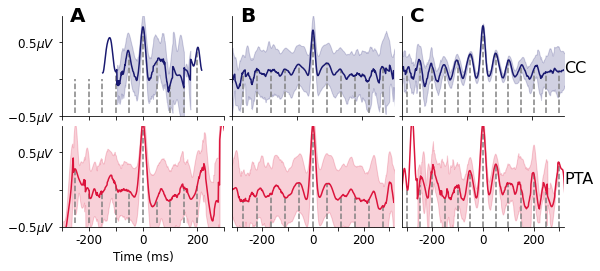

In [14]:
mouse_frx = [19,21]
lfp_frx = [16,20]
ecog_frx  = [19,21]
phase = False
mouse_f = mouse.loc[(mouse['freq'] >= mouse_frx[0]) & (mouse['freq'] <= mouse_frx[1])]
cc_mouse, pt_mouse = plot2.find_burst_data(mouse_f,phase)
lfp_f = lfp.loc[(lfp['freq'] >= lfp_frx[0]) & (lfp['freq'] <= lfp_frx[1])]
cc_lfp, pt_lfp = plot2.find_burst_data(lfp_f,phase)
ecog_f = ecog.loc[(ecog['freq'] >= ecog_frx[0]) & (ecog['freq'] <= ecog_frx[1])]
cc_ecog, pt_ecog = plot2.find_burst_data2(ecog_f,phase)

ylims = [-0.45,0.85]
dash = 'gray'
plot2.brp(
        cc_mouse,pt_mouse,mouse_frx,
        cc_lfp,pt_lfp,lfp_frx,
        cc_ecog,pt_ecog,ecog_frx,
        ylims, dash)

# What can we say about behavior?

Given that the bursts we find seem to be found in unique locations we wondered if they might be distributed differently across the trial structure. Below in **A** we first calculated for each trial the number of bursts for each method, we then split this calculation by **S**earch and **R**epetition trials in the leftmost panel. In the middle we calculated for each recording location the ratio of Search to Repetition we observed in the behavioral data and plotted this against the same ratio but calculated with the bursts. If the burst data was in an equal proportion as seen in the behavioral it would lie on the straight line.  We went ahead and tested this with a 1-sided paired permutation test and found that the CC burst ratio was greater than what was found in the behavioral data, and the PT method burst ratio was less. This means that CC bursts are more likely to be found in the search epoch, and PT burst more likely in the repetition epoch. In **B** we find the same exact pattern in the ECoG data. 

**C** are violinplots of the duration, amplitude, and frequency split by both the method, and the Search or Repetition behavior for monkey Pablo, Marco, and the ECoG data. While it is quite clear, just like as before, that the different methods find very different bursts, the picture of how these characteristics play out with behavior is not nearly as clear. 

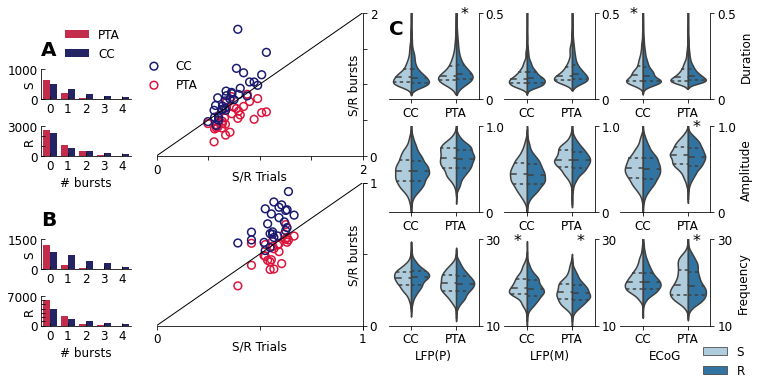

In [15]:
pt_lfp_b, pt_lfp_c      = plot3.behav(lfp,lfp_bs,lfp_trials,'pt', lfp_ids)
cc_lfp_b, cc_lfp_c      = plot3.behav(lfp,lfp_bs,lfp_trials,'cc', lfp_ids)
pt_ecog_b, pt_ecog_c    = plot3.behav(ecog,ecog_bs,ecog_trials,'pt',ecog_ids)
cc_ecog_b, cc_ecog_c    = plot3.behav(ecog,ecog_bs,ecog_trials,'cc',ecog_ids)

vio_col = 'Paired'
plot3.plot_beh(pt_lfp_b,pt_lfp_c,cc_lfp_b,cc_lfp_c,pt_ecog_b,pt_ecog_c,cc_ecog_b,cc_ecog_c,ecog,marco,pablo,vio_col,False)

In [16]:
count_lfp = pd.concat([pt_lfp_c,cc_lfp_c])
count_ecog = pd.concat([pt_ecog_c,cc_ecog_c])
behav_lfp = pd.concat([pt_lfp_b,cc_lfp_b])
behav_lfp['monkey'] = behav_lfp['loc'].astype(str).str[0]
behav_ecog = pd.concat([pt_ecog_b,cc_ecog_b])
behav_marco = behav_lfp[(behav_lfp.monkey=='M')]
behav_pablo = behav_lfp[(behav_lfp.monkey=='P')]

In [17]:
plot3.np_test(behav_marco,'marco','pt')
plot3.np_test(behav_marco,'marco','cc')
plot3.np_test(behav_pablo,'pablo','pt')
plot3.np_test(behav_pablo,'pablo','cc')
plot3.np_test(behav_ecog,'ecog','pt')
plot3.np_test(behav_ecog,'ecog','cc')

[0, 0.0]
[13, 14]
[64, 0.0064]
[10, 14]
[3, 0.0003]
[15, 17]
[57, 0.0057]
[14, 17]
[32, 0.0032]
[20, 25]
[0, 0.0]
[23, 25]


(0, 0.0)

In [18]:
plot3.print_stats2(marco,'marco','pt','duration')
plot3.print_stats2(marco,'marco','pt','amp')
plot3.print_stats2(marco,'marco','pt','freq')
plot3.print_stats2(marco,'marco','cc','duration')
plot3.print_stats2(marco,'marco','cc','amp')
plot3.print_stats2(marco,'marco','cc','freq')

--------------------------------------------
marco
duration
pt
search: 0.16167412280090504 repeat 0.1714397389876725
Ttest_relResult(statistic=-1.7633779334097552, pvalue=0.10131030435302836)
[893, 0.0893]
-0.5960406411967935
--------------------------------------------
marco
amp
pt
search: 0.6217085038060127 repeat 0.6057801154487782
Ttest_relResult(statistic=1.9926500568159207, pvalue=0.06772541435970782)
[670, 0.067]
0.4717494606074685
--------------------------------------------
marco
freq
pt
search: 17.975449614612305 repeat 17.653523482066984
Ttest_relResult(statistic=2.5874490533877803, pvalue=0.02253613090246862)
[229, 0.0229]
0.5928911935115179
--------------------------------------------
marco
duration
cc
search: 0.130640973965806 repeat 0.12964747161763157
Ttest_relResult(statistic=0.36863055612341933, pvalue=0.7183367348396279)
[7157, 0.7157]
0.098313003558293
--------------------------------------------
marco
amp
cc
search: 0.4544005439330396 repeat 0.44390840156548655
Tte

In [19]:
plot3.print_stats2(pablo,'pablo','pt','duration')
plot3.print_stats2(pablo,'pablo','pt','amp')
plot3.print_stats2(pablo,'pablo','pt','freq')
plot3.print_stats2(pablo,'pablo','cc','duration')
plot3.print_stats2(pablo,'pablo','cc','amp')
plot3.print_stats2(pablo,'pablo','cc','freq')

--------------------------------------------
pablo
duration
pt
search: 0.15842998019468815 repeat 0.1701570355561551
Ttest_relResult(statistic=-2.47221521617532, pvalue=0.025033279369145036)
[286, 0.0286]
-0.2849296452696725
--------------------------------------------
pablo
amp
pt
search: 0.640546540304511 repeat 0.6244251145624906
Ttest_relResult(statistic=1.878293378646532, pvalue=0.07868862995194623)
[768, 0.0768]
0.2961171128255816
--------------------------------------------
pablo
freq
pt
search: 20.18751808963766 repeat 19.868536204666857
Ttest_relResult(statistic=1.942398553545238, pvalue=0.06990323828550404)
[723, 0.0723]
0.28227728325651213
--------------------------------------------
pablo
duration
cc
search: 0.1422481751841313 repeat 0.14516499202083502
Ttest_relResult(statistic=-1.3086013732700865, pvalue=0.20915546160031584)
[2002, 0.2002]
-0.23829333294151503
--------------------------------------------
pablo
amp
cc
search: 0.49096534108652595 repeat 0.4893165802021998
T

In [20]:
plot3.print_stats2(ecog,'ecog','pt','duration')
plot3.print_stats2(ecog,'ecog','pt','amp')
plot3.print_stats2(ecog,'ecog','pt','freq')
plot3.print_stats2(ecog,'ecog','cc','duration')
plot3.print_stats2(ecog,'ecog','cc','amp')
plot3.print_stats2(ecog,'ecog','cc','freq')

--------------------------------------------
ecog
duration
pt
search: 0.15069571887399166 repeat 0.15290972144211262
Ttest_relResult(statistic=-0.8558214865415816, pvalue=0.4005604505913821)
[4078, 0.4078]
-0.203255761908697
--------------------------------------------
ecog
amp
pt
search: 0.6543449490488937 repeat 0.6406407671992504
Ttest_relResult(statistic=2.8356623070558613, pvalue=0.009138221122784024)
[91, 0.0091]
0.5386587341290643
--------------------------------------------
ecog
freq
pt
search: 20.083625361551597 repeat 19.720349957940712
Ttest_relResult(statistic=3.3366920091616366, pvalue=0.002753592586131181)
[26, 0.0026]
0.7529117478890656
--------------------------------------------
ecog
duration
cc
search: 0.16169162838863482 repeat 0.15730626078386997
Ttest_relResult(statistic=3.6060133640765666, pvalue=0.0014162560044145465)
[19, 0.0019]
0.7091227696650247
--------------------------------------------
ecog
amp
cc
search: 0.5130453566795168 repeat 0.5100049085748238
Ttest